# Exploratory Analysis and Visualization

This notebook focuses on **exploratory data analysis and visualization** using the aggregated tables generated in the previous steps. By leveraging pre-processed CSV files, the analysis emphasizes interpretation, pattern discovery, and insight generation rather than data preparation. The goal is to evaluate performance across locations, time, vendors, and products using visual and statistical techniques that support data-driven decision-making.


## Imports and helper functions
Imports the core libraries used throughout the notebook (Pandas/NumPy for data handling and Matplotlib/Seaborn for plotting) and loads custom plotting/formatting helpers used for the map, monthly trend chart, donut charts, confidence intervals, and currency formatting.

In [1]:
import pandas as pd
import os
import numpy as np
from plotting import displayMap,salesMonth,displayDonut,confidence_interval_plot,format_dollars

import matplotlib.pyplot as plt
import seaborn as sns

## Load location-level profit aggregation
Loads the precomputed location profit aggregation table from CSV (`location_profit_report.csv`) into a DataFrame.

In [2]:

df_map=pd.read_csv("location_profit_report.csv")
df_map.head()

,location,store_count,total_profit,region
0,LONDON,2,15158425.74,London
1,BRISTOL,6,13294978.58,South West
2,MANCHESTER,3,11629426.03,North West
3,BIRMINGHAM,2,8363023.42,West Midlands
4,NEWCASTLE,1,6587710.01,North East


## Visualize profit by location on a map
Uses the custom `displayMap` helper to render a geographic visualization of profitability across locations based on the location-level aggregation. The map is interactive: by hovering over each region, additional information such as the **number of stores** and **total regional profit** is displayed, enabling intuitive exploration and comparison across regions.


In [3]:
#displayMap(df_map)
m = displayMap(df_map)
m.save("uk_profit_map.html")
from IPython.display import IFrame

IFrame(
    src="uk_profit_map.html",
    width="100%",
    height=600
)


## Load monthly profit aggregation
Loads the precomputed monthly profit aggregation table from CSV (`monthly_profit_report.csv`) to enable time-series analysis of profitability.

In [4]:
df=pd.read_csv("monthly_profit_report.csv")
df

,sales_month,total_profit
0,January,9389697.00
1,February,9045285.02
2,March,9058511.13
3,April,9584995.49
4,May,11237094.47
5,June,12328666.28
6,July,15479007.95
7,August,12361078.65
8,September,12045823.30
9,October,11393879.40


## Visualize monthly profit trend
Uses the custom `salesMonth` helper to plot profit over time at a monthly granularity, making it easier to spot trends and seasonality.

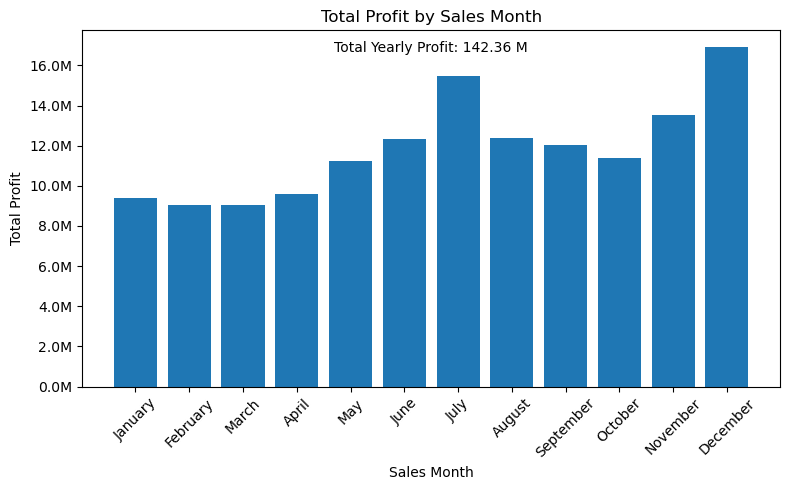

In [5]:
salesMonth(df)

## Load vendor-level performance aggregation
Loads the vendor/brand performance table from CSV (`vendor_report.csv`).

In [6]:
df1=pd.read_csv("vendor_report.csv")
df1.head(3)

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,TotalSalesDollars,TotalExciseTax,GrossProfit,ProfitMargin,SalesToPurchaseRatio,average_onhand,StockTurnover
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750.0,145080.0,3811251.60,142049.0,5254392.51,260999.20,1443140.91,27.47,1.38,13559.5,10.48
1,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,24.99,1750.0,187407.0,3418303.68,187140.0,4676628.60,343854.07,1258324.92,26.91,1.37,15483.5,12.09
2,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,1750.0,164038.0,3804041.22,160247.0,4645560.53,294438.66,841519.31,18.11,1.22,10409.5,15.39


## Count negative-profit records
Counts how many rows have negative `GrossProfit`, which is a quick data-quality check to detect cases where the economics appear inconsistent (e.g., costs exceeding revenue).

In [7]:
count = (df1['GrossProfit'] < 0).sum()
print(count)

1792


## Inspect negative-profit cases driven by pricing
Counts the subset of negative-profit rows where `PurchasePrice` is greater than `ActualPrice`, helping confirm that negative margins are associated with unfavorable price relationships.

In [8]:
print(df1[(df1['GrossProfit'] < 0) & (df1['PurchasePrice'] > df1['ActualPrice'])].shape[0])

0


## Remove negative-profit rows for cleaner analysis
Since there are **0 cases** where the purchase price exceeds the actual selling price, the negative-profit records are not driven by unfavorable pricing. Instead, these rows likely correspond to products or brands that remain in stock and have not yet been sold. Because our analysis focuses on realized performance based on completed sales, these records do not provide meaningful insights and should be removed. Excluding them ensures that subsequent analysis reflects only sold items and economically valid transactions.
Creates a mask for negative `GrossProfit` and drops those rows from the dataset so that subsequent visualizations and summary statistics focus on valid, economically meaningful records.


In [9]:
mask = (df1['GrossProfit'] < 0)
df1 = df1.drop(df1[mask].index)


## Explore numeric distributions
Selects numeric columns (excluding identifiers like vendor/brand/volume) and plots histograms for each metric. This helps understand spread, skewness, and outliers across sales, purchases, profit, margins, taxes, and inventory-related fields.

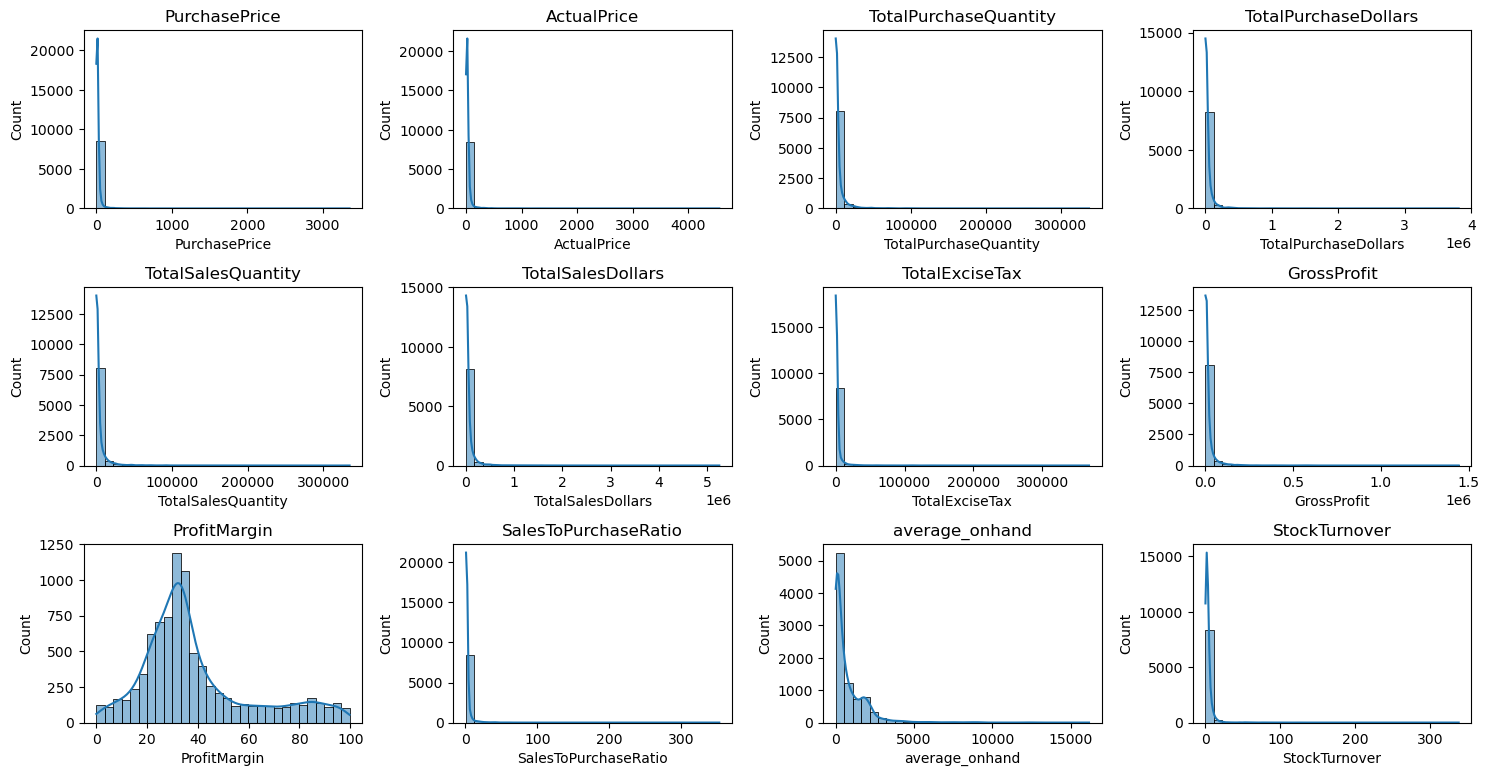

In [10]:

import matplotlib.pyplot as plt
import seaborn as sns

exclude_cols = ['VendorNumber', 'Brand','Volume']  # whatever you want to exclude

numerical_cols = [
    col for col in df1.select_dtypes(include=np.number).columns
    if col not in exclude_cols
]

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 4, i+1)  # Adjust grid layout as needed
    sns.histplot(df1[col], kde=True, bins=30)
    plt.title(col)
plt.tight_layout()
plt.show()

## Explore categorical frequency (top categories)
Creates count plots for key categorical columns (e.g., `VendorName`, `Description`) to see which vendors/products appear most often and to understand category dominance in the dataset.

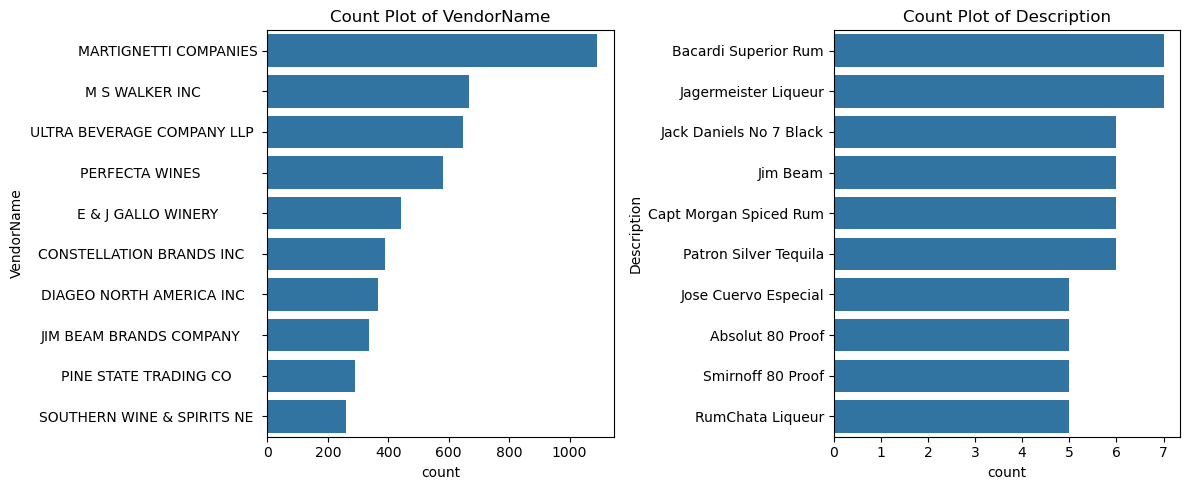

In [11]:
# Count Plots for Categorical Columns
categorical_cols = ["VendorName", "Description"]

plt.figure(figsize=(12, 5))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, 2, i+1)
    sns.countplot(y=df1[col], order=df1[col].value_counts().index[:10])  # Top 10 categories
    plt.title(f"Count Plot of {col}")
plt.tight_layout()
plt.show()

## Correlation analysis of numeric metrics
Computes a correlation matrix for the numeric features. This highlights relationships between financial and operational variables.

1. **PurchasePrice** shows almost no relationship with **TotalSalesDollars** or **GrossProfit**, indicating that changes in purchase price have minimal influence on overall revenue and profitability.

2. The near-perfect correlation between **total purchase quantity** and **total sales quantity** highlights strong inventory alignment and effective stock movement.

3. The inverse relationship between **ProfitMargin** and **total sales price** suggests that higher selling prices are associated with lower margins, likely reflecting competitive pricing pressures or discounting strategies.



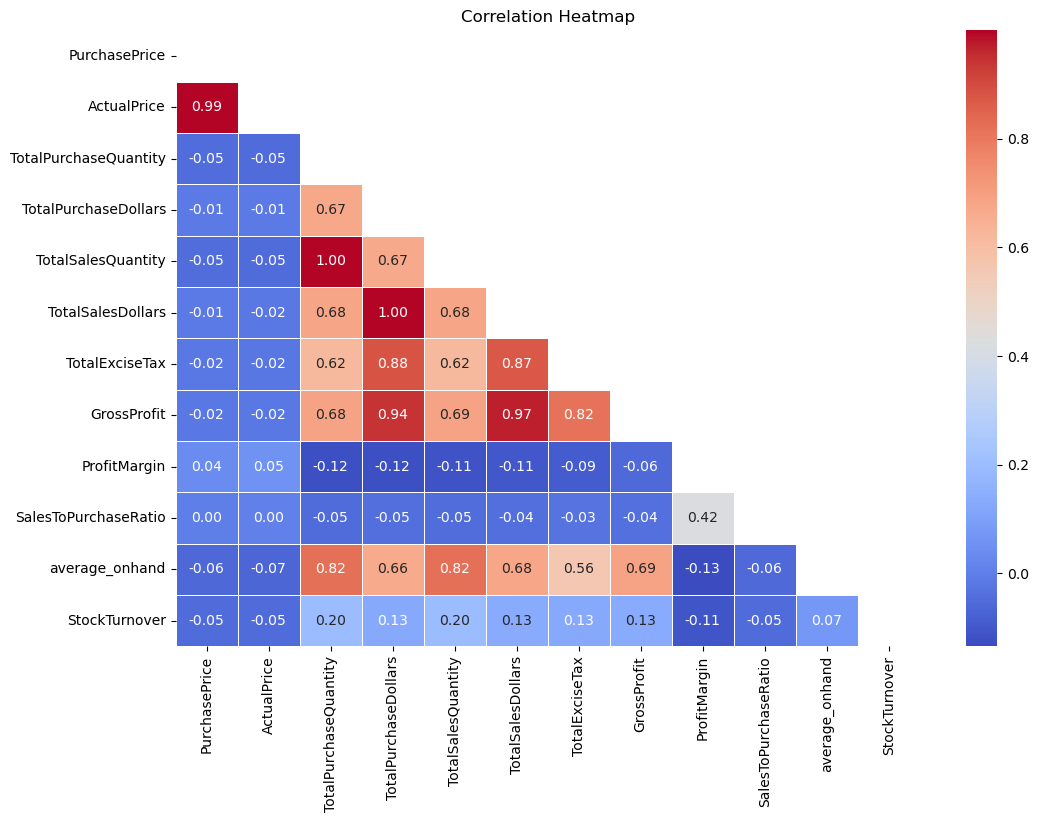

In [12]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df1[numerical_cols].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # True for upper triangle

sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

## Segment brands by sales and margin
Builds a small brand-focused dataset (`Description`, `TotalSalesDollars`, `ProfitMargin`) and creates binned categories:
- `SalesBin`: Low vs High sales (based on a sales quantile threshold)
- `MarginBin`: Low vs High margin (based on a margin quantile threshold)
These bins enable simple performance segmentation for visualization.

In [13]:
brand_performance=df1[['Description','TotalSalesDollars','ProfitMargin']]
brand_performance.sort_values('ProfitMargin')

brand_performance = brand_performance.copy()


# threshold for "low sales" (bottom 30%) and "high margin" (top 30%)
low_sales_threshold = brand_performance['TotalSalesDollars'].quantile(0.3)
high_margin_threshold = brand_performance['ProfitMargin'].quantile(0.7)

# Create binned categories based on your thresholds
brand_performance.loc[:, "SalesBin"] = pd.cut(
    brand_performance["TotalSalesDollars"],
    bins=[-float("inf"), low_sales_threshold, float("inf")],
    labels=["Low Sales Price", "High Sales Price"]
)

brand_performance.loc[:, "MarginBin"]  = pd.cut(
    brand_performance["ProfitMargin"],
    bins=[-float("inf"), high_margin_threshold, float("inf")],
    labels=["Low Margin", "High Margin"]
)

brand_performance.sort_values('ProfitMargin').head()

,Description,TotalSalesDollars,ProfitMargin,SalesBin,MarginBin
9381,Beringer Classic Moscato,207.84,0.00,Low Sales Price,Low Margin
9441,Pepperjack Barossa Red,191.92,0.02,Low Sales Price,Low Margin
9844,Flint & Steel Svgn Bl Napa V,119.92,0.03,Low Sales Price,Low Margin
9458,Croft Tawny Porto,191.84,0.04,Low Sales Price,Low Margin
9717,Douglass Hill Merlot,143.76,0.08,Low Sales Price,Low Margin


## Heatmap of brand distribution by segment
Creates a 2×2 cross-tab (MarginBin × SalesBin) and plots it as a heatmap to show how many brands fall into each quadrant (e.g., High Sales/High Margin vs Low Sales/Low Margin).

Most brands fall into the Low Margin–High Sales Price category, indicating that many high-priced products generate volume but operate on thin margins. A smaller group of brands achieves High Margin–High Sales Price, representing the strongest overall performers.

Importantly, brands with Low Sales Price and High Margin stand out as an opportunity. These products are cost-efficient and profitable per unit, suggesting that increasing their sales volume through promotion or wider distribution could significantly improve overall profitability.

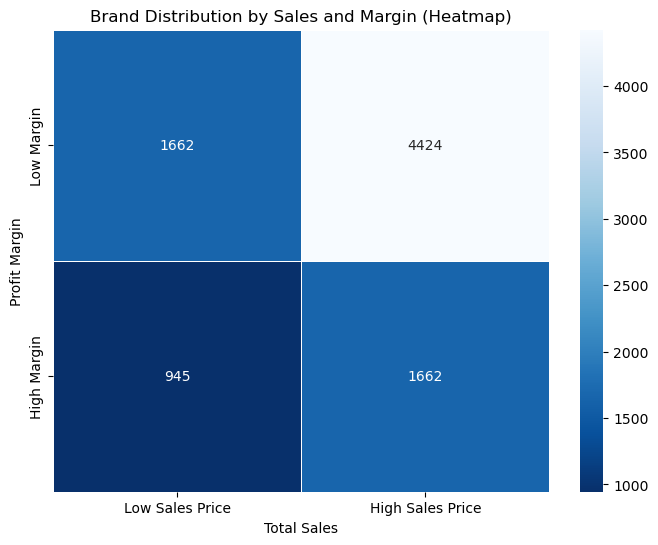

In [14]:
# Create 2x2 matrix
heatmap_data = pd.crosstab(
    brand_performance["MarginBin"],
    brand_performance["SalesBin"]
)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt="d",
    cmap="Blues_r",
    linewidths=0.5
)

plt.xlabel("Total Sales")
plt.ylabel("Profit Margin")
plt.title("Brand Distribution by Sales and Margin (Heatmap)")
plt.show()

## Identify top vendors and top brands by sales
Aggregates total sales dollars by vendor and by product/brand description and extracts the top 10 in each group for focused comparison in the next visualization.

In [15]:
# Top Vendors & Brands by Sales Performance
top_vendors = df1.groupby("VendorName")["TotalSalesDollars"].sum().nlargest(10)
top_brands = df1.groupby("Description")["TotalSalesDollars"].sum().nlargest(10)

## Plot top 10 vendors and brands
Creates side-by-side horizontal bar charts for the top 10 vendors and top 10 brands by sales. 

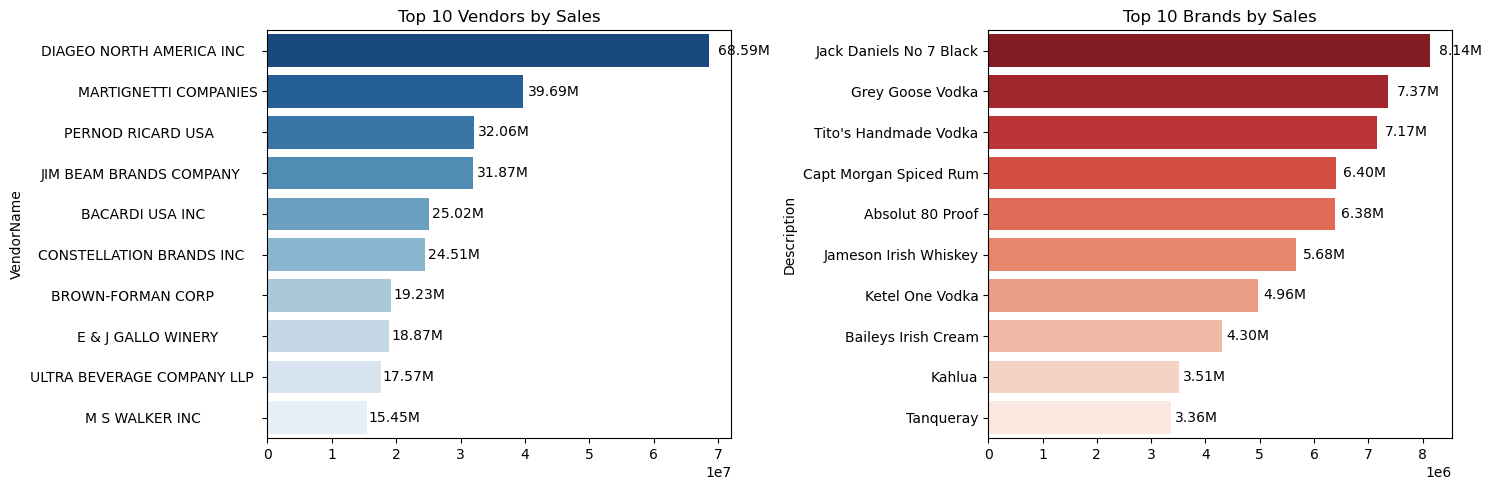

In [16]:


plt.figure(figsize=(15, 5))

# Plot for Top Vendors
plt.subplot(1, 2, 1)
ax1 = sns.barplot(
    y=top_vendors.index,
    x=top_vendors.values,
    hue=top_vendors.index,   # Add hue matching y variable
    palette="Blues_r",
    legend=False             # Hide legend since hue duplicates y
)
plt.title("Top 10 Vendors by Sales")

for bar in ax1.patches:
    ax1.text(
        bar.get_width() + (bar.get_width() * 0.02), 
        bar.get_y() + bar.get_height() / 2, 
        format_dollars(bar.get_width()), 
        ha='left', va='center', fontsize=10, color='black'
    )

# Plot for Top Brands
plt.subplot(1, 2, 2)
ax2 = sns.barplot(
    y=top_brands.index.astype(str),
    x=top_brands.values,
    hue=top_brands.index.astype(str),  # Add hue matching y variable
    palette="Reds_r",
    legend=False                       # Hide legend since hue duplicates y
)
plt.title("Top 10 Brands by Sales")

for bar in ax2.patches:
    ax2.text(
        bar.get_width() + (bar.get_width() * 0.02), 
        bar.get_y() + bar.get_height() / 2, 
        format_dollars(bar.get_width()), 
        ha='left', va='center', fontsize=10, color='black'
    )

plt.tight_layout()
plt.show()


## Build vendor performance summary and derived metrics
Aggregates key metrics per vendor (total purchases, total sales, gross profit, excise tax, average stock turnover) and derives additional performance fields such as net profit after excise Tax and each vendor’s contribution to total purchasing.

This table shows the vendors with the **highest total purchase dollars**, highlighting those that contribute most to overall procurement spend, alongside key performance and profitability metrics.


In [17]:
# Rank Vendors by Total Purchase Dollars
vendor_performance = df1.groupby("VendorName").agg({
    "TotalPurchaseDollars": "sum",
    "TotalSalesDollars":"sum",
    "GrossProfit": "sum",
    
    "TotalExciseTax":"sum",
    "StockTurnover":"mean"
    
    
}).reset_index()

vendor_performance["NetProfitAfterExcise"]=vendor_performance["GrossProfit"]-vendor_performance["TotalExciseTax"]

vendor_performance["NetProfitPct%"]=round((vendor_performance["NetProfitAfterExcise"]/vendor_performance["TotalPurchaseDollars"])*100,2)

# Calculate Contribution % to Overall Procurement
vendor_performance["Purchase_Contribution%"] = round((vendor_performance["TotalPurchaseDollars"] / vendor_performance["TotalPurchaseDollars"].sum()) * 100,2)
vendor_performance["StockTurnover"] = round(vendor_performance["StockTurnover"],2)

# Rank Vendors by Total Purchase Dollars & Profitability
vendor_performance1 = vendor_performance.sort_values(by="TotalPurchaseDollars", ascending=False)

# Display Top 10 Vendors by TotalPurchaseDollars
top_vendors = vendor_performance1.head(10).copy()
top_vendors["Purchase_Contribution%"] = round(top_vendors["Purchase_Contribution%"], 2)

top_vendors['TotalSalesDollars'] = top_vendors['TotalSalesDollars'].apply(format_dollars)
top_vendors['TotalPurchaseDollars'] = top_vendors['TotalPurchaseDollars'].apply(format_dollars)
top_vendors['GrossProfit'] = top_vendors['GrossProfit'].apply(format_dollars)
top_vendors['TotalExciseTax'] = top_vendors['TotalExciseTax'].apply(format_dollars)
top_vendors['NetProfitAfterExcise'] = top_vendors['NetProfitAfterExcise'].apply(format_dollars)

def highlight_column_bold(s):
    return ['font-weight: bold; color: red'] * len(s)


styled_vendors =top_vendors.copy()
styled_vendors = styled_vendors.astype(str)
styled_vendors.head(5).style.apply(highlight_column_bold, subset=['TotalPurchaseDollars'], axis=0)

,VendorName,TotalPurchaseDollars,TotalSalesDollars,GrossProfit,TotalExciseTax,StockTurnover,NetProfitAfterExcise,NetProfitPct%,Purchase_Contribution%
25,DIAGEO NORTH AMERICA INC,50.42M,68.59M,18.17M,3.79M,7.86,14.39M,28.53,16.2
56,MARTIGNETTI COMPANIES,25.96M,39.69M,13.73M,746.13K,3.1,12.98M,50.01,8.34
68,PERNOD RICARD USA,23.92M,32.06M,8.14M,1.50M,3.05,6.65M,27.79,7.69
45,JIM BEAM BRANDS COMPANY,23.65M,31.87M,8.22M,2.24M,4.94,5.98M,25.3,7.6
6,BACARDI USA INC,17.57M,25.02M,7.46M,1.36M,3.72,6.09M,34.68,5.64


## Top vendors by net profit percentage
This table displays vendors ranked by **NetProfitPct%**, highlighting those with the highest profitability relative to their purchase spend.


In [18]:
vendor_performance2 = round(vendor_performance.sort_values(by="NetProfitPct%", ascending=False),2)
# Display Top 10 Vendors by NetProfitPct%
top_vendors1 = vendor_performance2[
    (vendor_performance2["TotalPurchaseDollars"] > 500000) &
    (vendor_performance2["NetProfitPct%"] > 49.99)
].copy()
top_vendors1['TotalSalesDollars'] = top_vendors1['TotalSalesDollars'].apply(format_dollars)
top_vendors1['TotalPurchaseDollars'] = top_vendors1['TotalPurchaseDollars'].apply(format_dollars)
top_vendors1['GrossProfit'] = top_vendors1['GrossProfit'].apply(format_dollars)
top_vendors1['TotalExciseTax'] = top_vendors1['TotalExciseTax'].apply(format_dollars)
top_vendors1['NetProfitAfterExcise'] = top_vendors1['NetProfitAfterExcise'].apply(format_dollars)

styled_vendors =top_vendors1.copy()
styled_vendors = styled_vendors.astype(str)
styled_vendors.head(5).style.apply(highlight_column_bold, subset=['NetProfitPct%'], axis=0)


,VendorName,TotalPurchaseDollars,TotalSalesDollars,GrossProfit,TotalExciseTax,StockTurnover,NetProfitAfterExcise,NetProfitPct%,Purchase_Contribution%
36,FREDERICK WILDMAN & SONS,695.97K,1.22M,528.34K,14.72K,2.11,513.62K,73.8,0.22
47,KOBRAND CORPORATION,1.78M,3.00M,1.22M,24.67K,2.32,1.20M,67.42,0.57
88,SOUTHERN WINE & SPIRITS NE,3.52M,5.88M,2.36M,49.51K,3.73,2.31M,65.43,1.13
7,BANFI PRODUCTS CORP,1.61M,2.67M,1.06M,32.75K,2.47,1.03M,63.9,0.52
67,PERFECTA WINES,4.70M,7.51M,2.81M,62.75K,2.88,2.75M,58.55,1.51


## Visualize purchase contribution using donut charts
Vendors with **net profit above 50%** contribute roughly **one-third of total purchases**, indicating that high profitability does not necessarily correspond to high purchasing volume. The **top 10 vendors** together account for about **two-thirds of total procurement**, reflecting strong supplier concentration. This presents an opportunity to increase purchasing from high-profit vendors or to improve margins among high-volume suppliers.


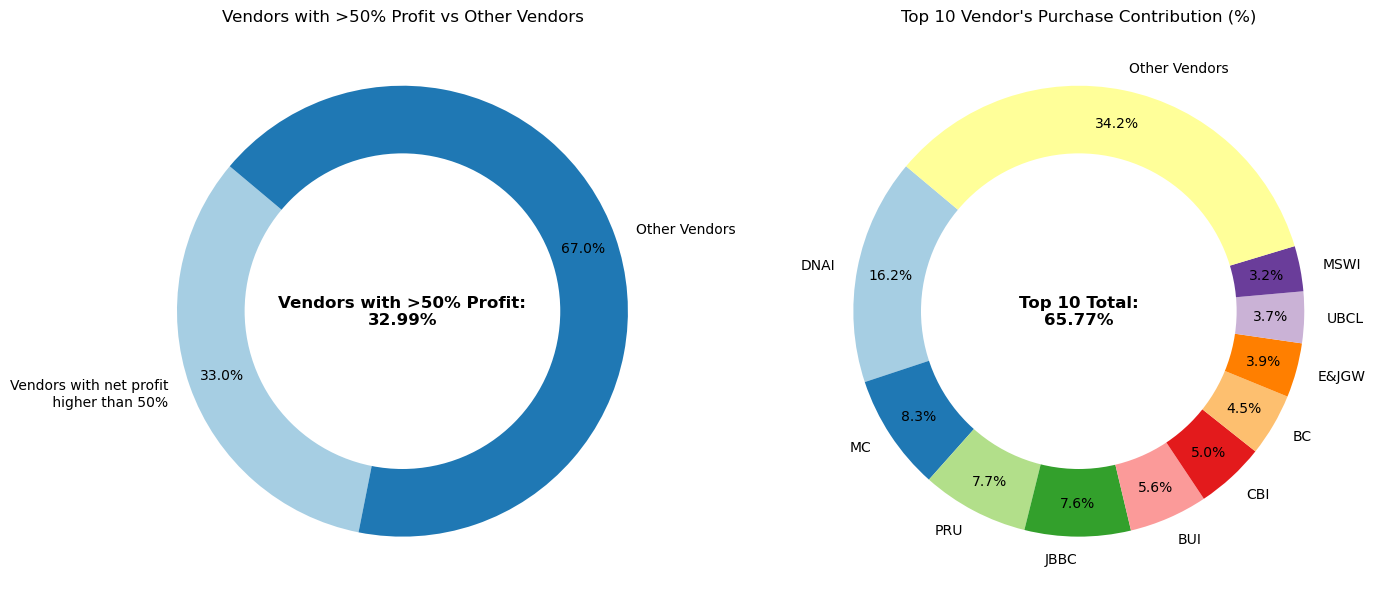

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))


vendors = ["Vendors with net profit\n higher than 50%"]
purchase_contributions = [round(top_vendors1['Purchase_Contribution%'].sum(),2)]
total_contribution = sum(purchase_contributions)
remaining_contribution = 100 - total_contribution

# Append "Other Vendors" category
vendors.append("Other Vendors")
purchase_contributions.append(remaining_contribution)
# ---------- Donut 1 ----------



displayDonut(axes[0],purchase_contributions,vendors,total_contribution,"Vendors with >50% Profit vs Other Vendors",plt.cm.Paired.colors,"Vendors with >50% Profit")

# ---------- Donut 2 (example: duplicate or different data) ----------
# Create abbreviations
abbreviations = top_vendors['VendorName'].apply(lambda x: ''.join([word[0].upper() for word in x.split()]))
vendors = list(abbreviations.values)
purchase_contributions = list(top_vendors['Purchase_Contribution%'].values)
total_contribution = sum(purchase_contributions)
remaining_contribution = 100 - total_contribution

# Append "Other Vendors" category
vendors.append("Other Vendors")
purchase_contributions.append(remaining_contribution)


displayDonut(axes[1],purchase_contributions,vendors,total_contribution,"Top 10 Vendor's Purchase Contribution (%)",plt.cm.Paired.colors,"Top 10 Total")



## Compare contribution vs profitability
Creates a combined chart for **vendors with net profit greater than 50%**, where bars represent each vendor’s purchase contribution (%) and the line shows net profit (%). 


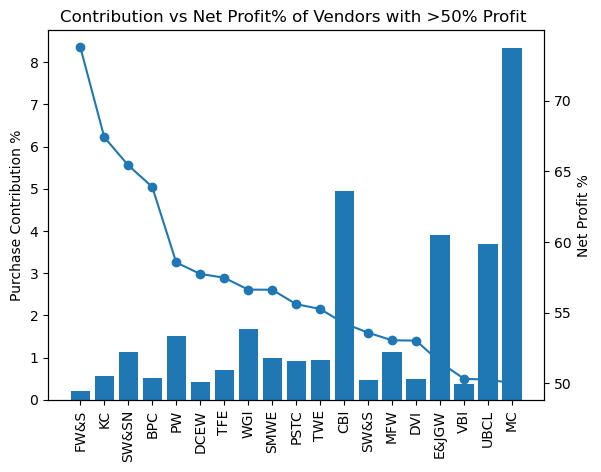

In [20]:
fig, ax1 = plt.subplots()
top_vendors1['VendorName'] = top_vendors1['VendorName'].apply(lambda x: ''.join([word[0].upper() for word in x.split()]))

ax1.bar(top_vendors1['VendorName'], top_vendors1['Purchase_Contribution%'])
ax1.set_ylabel('Purchase Contribution %')

ax2 = ax1.twinx()
ax2.plot(top_vendors1['VendorName'], top_vendors1['NetProfitPct%'], marker='o')
ax2.set_ylabel('Net Profit %')

plt.title('Contribution vs Net Profit% of Vendors with >50% Profit ')
ax1.tick_params(axis='x', labelrotation=90)
plt.show()




## Summarize cost and margin by order size
Aggregates the unit economics by `OrderSize` (intended to compute median `UnitPurchasePrice` and `UnitGrossProfit` per size bucket). This provides a simple view of whether larger orders are associated with lower unit costs or higher unit gross profit.

In [21]:
# Calculate Unit Purchase Price per Vendor & Volume Group
df1["UnitPurchasePrice"] = df1["TotalPurchaseDollars"] / df1["TotalPurchaseQuantity"]
df1["UnitGrossProfit"] = df1["GrossProfit"] / df1["TotalPurchaseQuantity"]



# Group by Order Sizes (e.g., Small, Medium, Large Purchases)
df1["OrderSize"] = pd.qcut(df1["TotalPurchaseQuantity"], q=3, labels=["Small", "Medium", "Large"])



bulk_purchase_analysis = (
    df1
    .groupby(["Brand", "OrderSize"], observed=True)["UnitPurchasePrice"]
    .mean()
    .reset_index()
    .dropna(subset=["UnitPurchasePrice"])
)

# Keep brands with at least 2 distinct OrderSize values
bulk_purchase_analysis = bulk_purchase_analysis[
    bulk_purchase_analysis
    .groupby("Brand")["OrderSize"]
    .transform("nunique") >= 2
]

# Analyze Cost Savings per Order Size
bulk_purchase_analysis = df1.groupby("OrderSize", observed=True)[["UnitPurchasePrice","UnitGrossProfit"]].median().reset_index()
print(bulk_purchase_analysis)


  OrderSize  UnitPurchasePrice  UnitGrossProfit
0     Small              12.83        14.470000
1    Medium              10.20         4.891530
2     Large               8.38         3.988943


## Identify low stock-turnover vendors
Filters vendors with `StockTurnover` below a threshold (e.g., < 1), computes average turnover per vendor, and sorts ascending to highlight the slowest-moving inventory partners.

In [22]:
# Identify Low Inventory Turnover Vendors
low_turnover_vendors = df1[df1["StockTurnover"] < 1].groupby("VendorName")["StockTurnover"].mean().reset_index()

# Sort by Lowest Turnover
low_turnover_vendors = low_turnover_vendors.sort_values(by="StockTurnover", ascending=True)
low_turnover_vendors.head(10)

,VendorName,StockTurnover
18,DISARONNO INTERNATIONAL LLC,0.040000
8,CAPSTONE INTERNATIONAL,0.070000
20,DUGGANS DISTILLED PRODUCTS,0.100000
69,SILVER MOUNTAIN CIDERS,0.160000
21,Dunn Wine Brokers,0.228000
31,"IRA GOLDMAN AND WILLIAMS, LLP",0.230000
61,R.P.IMPORTS INC,0.255946
23,EDRINGTON AMERICAS,0.272143
53,PARK STREET IMPORTS LLC,0.290000
58,POVERTY LANE ORCHARDS,0.310000


## Rank vendors by turnover and contribution fields
Creates a compact view of vendors with `StockTurnover`, `NetProfitPct%`, and `Purchase_Contribution%`, then sorts to rank vendors for comparison (useful for spotting high-impact vendors with low turnover or vice versa).

In [23]:
low_turnover_vendors = vendor_performance[["VendorName","StockTurnover","NetProfitPct%","Purchase_Contribution%"]]

low_turnover_vendors = low_turnover_vendors.sort_values(by="StockTurnover", ascending=False)
low_turnover_vendors.head(10)

,VendorName,StockTurnover,NetProfitPct%,Purchase_Contribution%
54,MANGO BOTTLING INC,11.40,25.06,0.07
25,DIAGEO NORTH AMERICA INC,7.86,28.53,16.20
79,SAZERAC CO INC,7.50,23.39,2.94
64,OLE SMOKY DISTILLERY LLC,6.14,28.16,0.12
49,LAIRD & CO,5.52,35.89,0.06
30,E & J GALLO WINERY,5.50,51.49,3.90
98,TAKARA SAKE USA INC,5.50,29.73,0.01
51,LUXCO INC,5.47,33.37,0.62
26,DISARONNO INTERNATIONAL LLC,5.38,38.34,0.37
24,DIAGEO CHATEAU ESTATE WINES,5.25,57.74,0.42


## Confidence interval comparison of profit margins
Splits vendors into higher- vs lower-sales groups using sales quantiles and compares their `ProfitMargin` distributions using a confidence-interval plot. This supports a statistical comparison of margins between top-performing and low-performing segments.

Top Vendors 95% CI: (31.21, 32.10), Mean: 31.65
Low Vendors 95% CI: (41.48, 43.50), Mean: 42.49


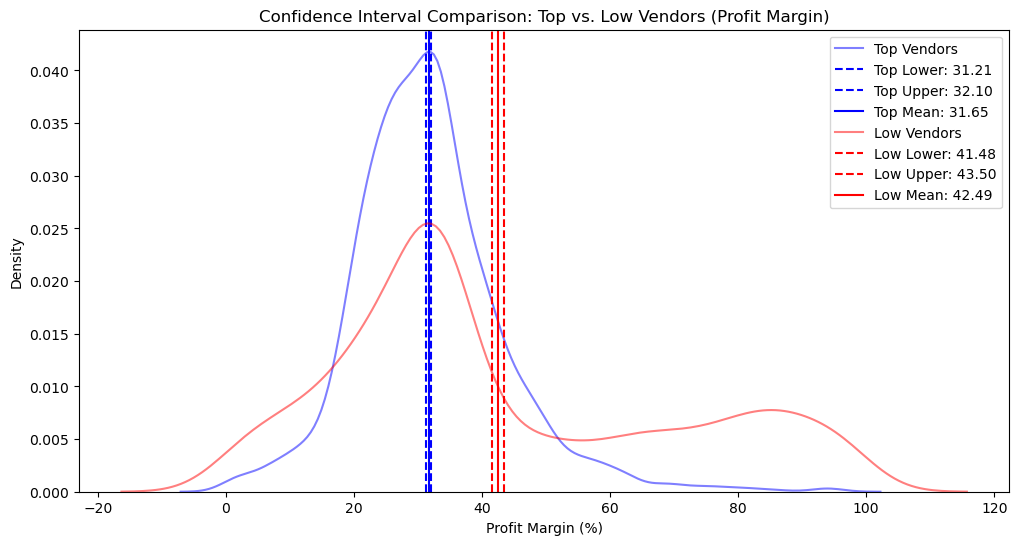

In [24]:


# Define top and low vendors based on Total Sales Dollars (Top 25% & Bottom 25%)
top_threshold = df1["TotalSalesDollars"].quantile(0.7)
low_threshold = df1["TotalSalesDollars"].quantile(0.3)

top_vendors = df1[df1["TotalSalesDollars"] >= top_threshold]["ProfitMargin"].dropna()
low_vendors = df1[df1["TotalSalesDollars"] <= low_threshold]["ProfitMargin"].dropna()

confidence_interval_plot(top_vendors,low_vendors)

